### pyAPES.microclimate.Micromet

- mean flow and turbulent diffusivity
- scalar concentration profiles in multi-layer canopies

Status (Jan 20th, 2025 / Samuli): demo for flow profile is done, scalar profile example must be added.
- in Demo of mlm_canopy: add visualization of iterative solution of microclimate and leaf and forestfloor C, water and energy budgets. Video of how microclimate and surface flux profiles change within iterative solution.

In [1]:
# setting path
import sys
#sys.path.append('c:\\Repositories\\pyAPES_main')
import os
from dotenv import load_dotenv

load_dotenv()
pyAPES_main_folder = os.getenv('pyAPES_main_folder')

sys.path.append(pyAPES_main_folder)
#print(sys.path)

# imports
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Micromet sub-model for turbulent flow and scalar exchange in canopies
from pyAPES.microclimate.micromet import Micromet

# functions used in Micromet
from pyAPES.microclimate.micromet import mixing_length, closure_1_model_U, closure_1_model_scalar

# leaf-area density from weibul - distribution
from pyAPES.utils.utilities import lad_weibul

### Mean flow, momentum flux and eddy diffusivity within and above horizontally homogeneous vegetation

- Launiainen et al., 2015. *Ecol. Mod.*, supplementary material

In a stationary and planar-homogeneous flow at high Reynolds number and with no subsidence and mean longitudinal pressure gradients, the mean momentum budget reduces to

$
\begin{equation}
\frac{\partial \overline{u'w'}}{\partial z}=-C_d \Lambda_{p,t} U(z)^2,
\end{equation}
$

where $\overline{u'w'}$ is turbulent shear stress, $C_d$ [-] a foliage drag coefficient, usually between 0.1 - 0.3, $\Lambda_{p,t}(z)$ [m2 m-3] the local plant area density and $U(z)$ the mean velocity profile.

The first-order closure for $\overline{u'w'}$ is
$
\begin{equation}
\overline{u'w'}=-K_m\frac{\partial U}{\partial z}, 
\end{equation}
$

where $K_m$ is the [m2 s-1] eddy diffusivity for momentum $K_m$

$
\begin{equation}
K_m=l^2\left| \frac{\partial U}{\partial z}\right|. 
\end{equation}
$

The effective mixing length $l$ [m] is given as

$
\begin{equation}
 l(z)=\begin{cases}
    k_v z, & z<(\alpha' h /k_v).\\
    \alpha' h, & \alpha' h /k_v \leq z < h_c \\ 
    k_v(z-d), & z \geq h,
  \end{cases}
\end{equation}
$

where $d$ is the zero-plane displacement height, $k_v = 0.4$ is the von Karman constant and $h$ is the canopy height. The parameter $ \alpha' $ ensure continuity (but not smoothness) in the mixing length.

Combining eq. 1 and 4 results in a homogenous second-order nonlinear ordinary differential equation (ODE)
$
\begin{equation}
K_m\frac{\partial ^2 U}{\partial ^2 z}+\frac{\partial K_m}{\partial z}\frac{\partial U}{\partial z}-C_d \Lambda_{p,t}U^2=0,
\end{equation}
$

Function *pyAPES.microclimate.closure_1_model_U()* solves eq. 5 for $U(z)$ and further $\overline{u'w'}(z)$ and $K_m(z)$ when upper and lower boundary condition (BC') and leaf-area density profile $\Lambda_{p,t}(z)$ are provided. The BC's can be given as measured $U$ or $U/u_*$ ($u_*$ is the friction velocity) at highest grid point while no-slip boundary (zero velocity) is often assumed at the ground.

### Micromet -class: sub-model for turbulent canopy flow & scalar (T, H2O, CO2) profiles

- canopy flow (eq. 1 - 5): *pyAPES.microclimate.micromet.closure_1_U()*
- scalar profiles: *pyAPES.microclimate.micromet.closure_1_scalar()*
- called from sub-daily loop of *pyAPES.canopy.mlm_canopy.run()*
- stores normalized flow statistics & previous scalar profiles as state variables

### Define parameters (similar to pyAPES.mlm_parameters)

In [3]:
# define model parameters

# --- Turbulent flow & scalar transport in air-space: pyAPES.microclimate.micromet.Micromet
micromet = {'zos': 0.01,  # forest floor roughness length [m]  -- not used
            'dPdx': 0.0,  # horizontal pressure gradient [units]
            'Cd': 0.15,  # drag coefficient [-]
            'Utop': 5.0,  # ensemble U/ustar at top boundary [-]
            'Ubot': 0.00,  # flow at lower boundary [-]
            'Sc': {'T': 2.0, 'H2O': 2.0, 'CO2': 2.0}  # turbulent Schmidt numbers in canopy flow
            }

# create grid
grid = {'zmax': 25.0,  # heigth of grid from ground surface. Corresponds to height of forcing data [m]
        'Nlayers': 101  # number of layers [-]
        }

z = np.linspace(0, grid['zmax'], grid['Nlayers'])  # grid [m] above ground

LAI = 1.0 # m2m-2, leaf-area index
hc = 15.0 #  m, canopy height
hb = 3.0 # m, crown base height

# create leaf-area density usign weibul-distribution [m2 m-3] 
# make sure hc < max(z) and there is at least one grid cell with zero lad at top!
# Thisis required in both pyAPES.microclimate.Micromet and pyAPES.microclimate.Radiation -submodels

lad = lad_weibul(z, LAI=3.0, h=hc, hb=hb, species='pine')    

# BC's for testing
ust = 0.5 # friction velocity at top [m s-1]
Utop = 5.0 # Upper BC, U/u* [-] 
Ubot = 0.0 # lower BC, U/u* [-]

# create model instance
model = Micromet(z, lad=lad, hc=hc, p=micromet)


Text(0.5, 1.0, "$\\overline{u'w'}$(z) [m2 s-2]")

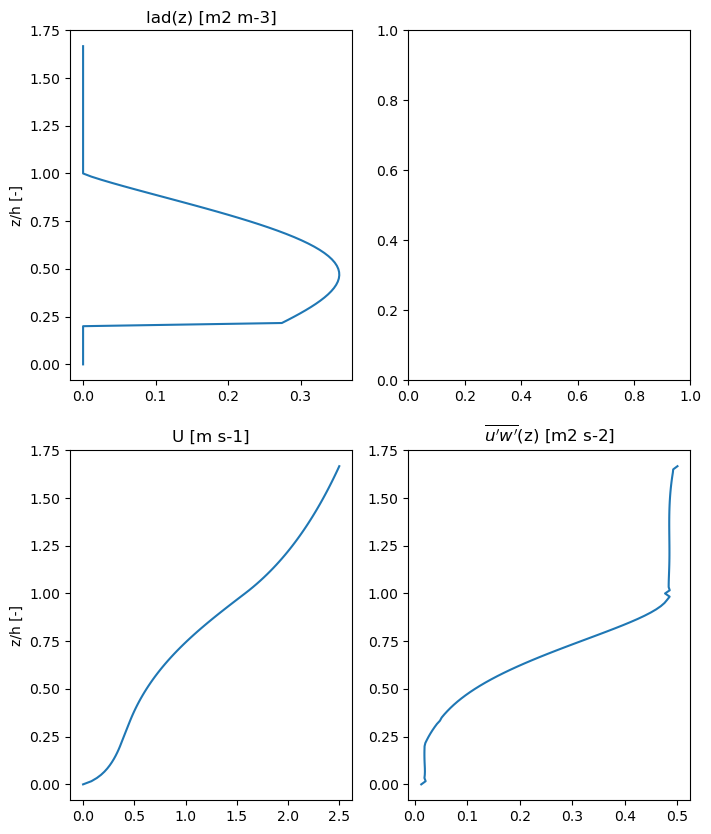

In [4]:
# plot state variables related to flow statistics
# multiply with u_* to move from normalized to actual profiles

fig, ax = plt.subplots(2,2, figsize=(8,10))

ax[0,0].plot(lad, z/hc, '-'); ax[0,0].set_title('lad(z) [m2 m-3]'); ax[0,0].set_ylabel('z/h [-]')

ax[1,0].plot(model.U_n * ust, z/hc, '-'); ax[1,0].set_title('U [m s-1]'); ax[1,0].set_ylabel('z/h [-]')
ax[1,1].plot(model.tau *ust , z/hc, '-'); ax[1,1].set_title("$\overline{u'w'}$(z) [m2 s-2]")

### *pyAPES.microclimate.micromet.closure_1_model_U()* 

- solves normalized shear-stress and mean flow profiles (eq. 5).
- is called when Micromet -instance in created
- setting *ctr['Eflow'] = True* in mlm_parameters uses ensemble flow statistics; i.e assumes Utop/ustar == constant. Remember to compute new profiles whenever lad-profile changes!
- the actual $U$, $u_*$  and $K_m$ profiles for each timestep are then computed with *model.update_state(forcing['friction_velocity'])*
- if *ctr['Eflow'] = False*, the profiles are solved for each timestep using upper BC = $Utop/u_*$ (slower, numerical problems possible)


Example: call pyAPES.microclimate.micromet.closure_1_model_U() directly and plot results

In [5]:

# solve u*-normalized momentum flux, U, Km, mixing length, displacement height and roughness lenght for momentum (eq. 1-5)
# u_* == at uppermost grid-point

# returns momentum flux, mean flow, eddy diffusivity, displacement height and momentum roughness length
tau_n, U_n, Km_n, l_mix, d, zo = closure_1_model_U(z=z, Cd=0.15, lad=lad, hc=hc, Utop=Utop, Ubot=Ubot)

zero-place displacement height d=9.88; roughness length z0=2.05


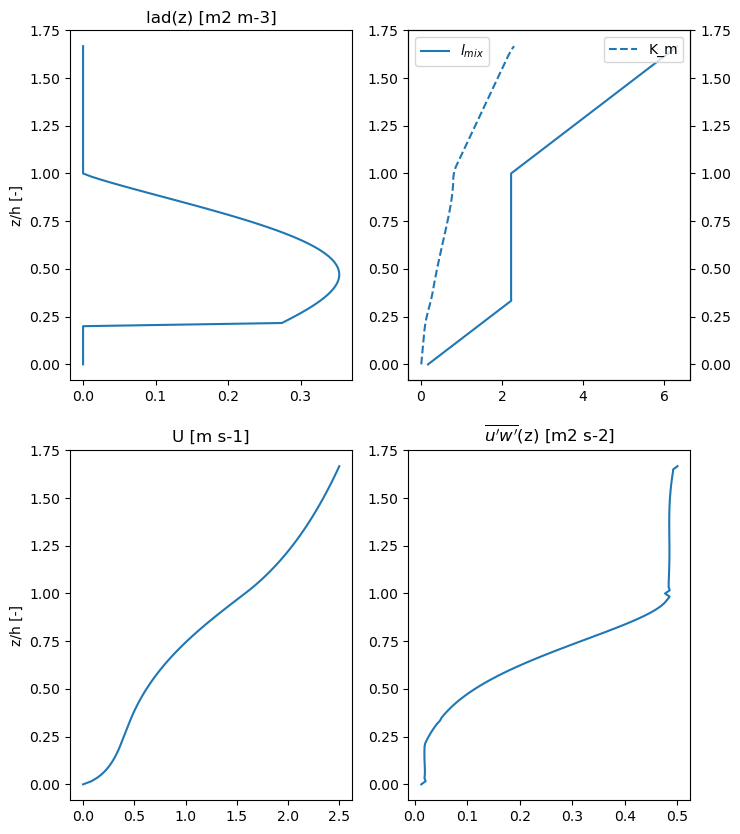

In [6]:
fig, ax = plt.subplots(2,2, figsize=(8,10))

ax[0,0].plot(lad, z/hc, '-'); ax[0,0].set_title('lad(z) [m2 m-3]'); ax[0,0].set_ylabel('z/h [-]')
ax[0,1].plot(l_mix, z/hc, '-', label='$l_{mix}$'); ax[0,1].legend()
axb = ax[0,1].twinx()
axb.plot(Km_n * ust, z/hc, '--', label='K_m'); axb.legend()

ax[1,0].plot(U_n * ust, z/hc, '-'); ax[1,0].set_title('U [m s-1]'); ax[1,0].set_ylabel('z/h [-]')
ax[1,1].plot(tau_n * ust, z/hc, '-'); ax[1,1].set_title("$\overline{u'w'}$(z) [m2 s-2]")

print('zero-place displacement height d=%.2f; roughness length z0=%.2f' % (d, zo))

### Scalar profiles in canopy air-space

- air temperature (T)
- air humidity, i.e. H2O mixing ratio [mol mol-1]
- CO2 mixing ratio [umol mol-1]
- any scalar can be easily added, given the BC's and correct sink/source profiles

The one-dimensional mean continuity equation of scalar $\overline{s}$ (s is e.g. $T$, $q$, $c_a$) in a canopy air space in stationary, planar homogenous flow in the absence of subsidence is (Juang et al. 2008):

$$
\begin{equation}
\frac{\partial \overline{w's'}}{\partial z}=S_s(z),
\end{equation}
$$
where $\overline{w's'}$ is the turbulent flux of $s$ and $S_s(z)$ the net sink / source term. Representing $\overline{w's'}$ using first order closure (as for momentum) leads to

$$
\begin{equation}
K_s\frac{\partial ^2 \overline{s}}{\partial ^2 z}+\frac{\partial K_s}{\partial z}\frac{\partial \overline{s}}{\partial z}+S_s(z)=0,
\end{equation}
$$

where $K_s(z)$  the scalar eddy diffusivity, often assumed equal (or multiplied by turbulent Schmidt number) to $K_m$. The $S_s(z)$ results from solving by coupled leaf gas- and energy exchange for each *PlantType* in the canopy, and computing $S_s(z)$ as lad(z) weighted mean of each *PlantType* (See: *pyAPES.mlm_canopy.CanopyModel.run()*). 

As for shear stress, eq. 2 can be solved given two BC's. The upper BC is a measured mixing ratio (or $T$) at the uppermost gridpoint, while the lower BC is typically flux-based, defined by soil surface - atmosphere $s$ exchange processes.
